In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns

from IPython.core.pylabtools import figsize

import numpy.random as r
from pylab import *
from matplotlib.gridspec import GridSpec

import sys
sys.path.insert(0, '../../utils')
import splicing_utils as spu
import single_cell_plots as scp
from single_cell_plots import *

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"


In [2]:
data_dir = '/mnt/c/Users/ferna/Desktop/SingleCell/data/'
%run -i '../../utils/load_data.py'

In [3]:
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import rpy2
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri as rpyn
from statsmodels.stats.multitest import multipletests
dt = rpy2.robjects.packages.importr('diptest')

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.stats import hypergeom
def hyper_test(M, n, N, k):
    
    hpd = hypergeom(M, n, N)
    p_depleted = hpd.cdf(k)
    p_enriched = hpd.sf(k-1)
    
    return p_depleted, p_enriched

In [4]:
mpl.rcParams["mathtext.fontset"] = "stix"

### Shalek bimodal events

In [5]:
shalek_int_genes, shalek_int_exons = spu.get_int_events(shalek_PSI, shalek_mrna_counts, 0.05)
shalek_int_exons = [x for x in shalek_int_exons if x in mrna_per_event_shalek.index]
shalek_PSI_filtered, shalek_PSI_mrna_filtered, shalek_good_exons, mrna_filtered, reads_filtered = filter_psi(shalek_PSI, 
                                            shalek_int_exons, mrna_per_event_shalek, shalek_coverage_tab['SJ_coverage'], 
                                                                        shalek_read_counts, 10,
                                                                       cell_min=0.5)

good_cells = shalek_PSI_filtered.columns[shalek_PSI_filtered.isna().mean() <= 0.5]
shalek_PSI_good = shalek_PSI_filtered[good_cells]


In [6]:
shalek_paper_bin_exon = ['Acpp_AE', 'Clec7a_other_1', 'Irgm1_1', 'Irf7_1', 'Clec4n_2', 'Sat1_nmdSE_1', 'Zfp207', 
                         'Abi1_7', 'Srsf7_nmdSE_1', 'Psmg4_1']

In [7]:
for event in [x for x in shalek_paper_bin_exon if x in shalek_PSI_filtered.index]:
    print(event)
    print(shalek_PSI.loc[event, mrna_per_event_shalek.columns].quantile(0.25))
    print(shalek_PSI.loc[event, mrna_per_event_shalek.columns].quantile(0.75))

Clec7a_other_1
0.0
0.13411938098747234
Irgm1_1
0.3618864292589028
0.5
Clec4n_2
0.5853566009104704
0.6755955139493929
Sat1_nmdSE_1
0.0014144271570014145
0.11048371917937136
Abi1_7
0.0995260663507109
0.6094674556213018
Srsf7_nmdSE_1
0.0
0.1562189054726368


In [8]:
sra_meta = pd.read_csv(data_dir + 'shalek/shalek.meta.tab', sep='\t', index_col=0)
shalek_PSI_paper = pd.read_csv(data_dir + 'shalek/shalek.psi_paper.csv', index_col = 0)
shalek_counts_paper = pd.read_csv(data_dir + 'shalek/shalek.expression_paper.csv', index_col = 0)
shalek_pca = pd.read_csv(data_dir + 'shalek/shalek.pca.tab', index_col = 0, sep='\t')
shalek_cells = shalek_PSI_paper.columns[1:18]

for event in shalek_paper_bin_exon:
    gen = event.split('_')[0]
    if len(shalek_PSI_paper.loc[shalek_PSI_paper.gene==gen, shalek_cells].index) >= 1:
        print(event)
        print(shalek_PSI_paper.loc[shalek_PSI_paper.loc[shalek_PSI_paper.gene==gen, shalek_cells].index[0],
                                         shalek_cells].quantile(0.25))
        print(shalek_PSI_paper.loc[shalek_PSI_paper.loc[shalek_PSI_paper.gene==gen, shalek_cells].index[0],
                                         shalek_cells].quantile(0.75))

Irgm1_1
0.19
0.98
Irf7_1
0.11
0.8899999999999999
Clec4n_2
0.515
0.665
Zfp207
0.0
0.20500000000000002
Abi1_7
0.395
0.9


### Song bimodal events

In [9]:
song_modalities = pd.read_csv(data_dir + 'song/song_event_modalities.tab', sep='\t', index_col = 0)
song_outrigger = pd.read_csv(data_dir + 'song/song_outrigger_psi.tab', index_col = 0)
outrigger_iPSC = [x for x in list(song_outrigger.index) if x[0] == 'P']
outrigger_NPC = [x for x in list(song_outrigger.index) if ((x[0] == 'C') or (x[0] == 'N'))]
outrigger_MN = [x for x in list(song_outrigger.index) if x[0] == 'M']

In [10]:
def get_proportions(PSI_tab, subpop, mrna_counts, mrna_per_event, read_counts, coverage_tab, psi_int = 0.1, mrna_min = 10,
                   outrigger_tab = '', outrigger_modalities = '', outrigger_subpop = '', outrigger_cell_type = ''):
    
    PSI_filtered = process_subpop(subpop, PSI_tab, mrna_counts, 
                                    mrna_per_event, read_counts, coverage_tab['SJ_coverage'], psi_int, mrna_min)
    
    PSI_observed = (PSI_tab[subpop].isna().mean(axis = 1) <= 0.5)
    PSI_int = (np.abs(0.5-PSI_tab[subpop].mean(axis = 1)) <= (0.5-psi_int))
    PSI_unfiltered = PSI_tab.loc[(PSI_observed & PSI_int), subpop]
    
    filtered_bimodal_by_song = 0
    unfiltered_bimodal_by_song = 0
    
    assert np.all([x in PSI_unfiltered.index for x in PSI_filtered[0].index])
    
    suma = len(PSI_unfiltered.index)
    suma_f = len(PSI_filtered[0].index)
    suma_unfiltered = 0
    suma_filtered_all = 0
    suma_filtered = 0
    suma_outrigger = 0
    suma_outrigger_total = 0

    for evento in PSI_unfiltered.index:

        q25_unfiltered = PSI_unfiltered.loc[evento].quantile(0.25)
        q75_unfiltered = PSI_unfiltered.loc[evento].quantile(0.75)
        if (q25_unfiltered <= 0.25) and (q75_unfiltered >= 0.75):
            suma_unfiltered += 1
            
        if len(outrigger_modalities) >= 1:
            if evento in outrigger_modalities.index:
                outrigger_event = outrigger_modalities.loc[evento, 'song_annotation']
                if outrigger_modalities.loc[evento, outrigger_cell_type] == 'bimodal':
                    unfiltered_bimodal_by_song += 1

        if evento in PSI_filtered[0].index:

            q25_filtered_all = PSI_tab.loc[evento, subpop].quantile(0.25)
            q75_filtered_all = PSI_tab.loc[evento, subpop].quantile(0.75)        
            if (q25_filtered_all <= 0.25) and (q75_filtered_all >= 0.75):
                suma_filtered_all += 1

            q25_filtered = PSI_filtered[0].loc[evento].quantile(0.25)
            q75_filtered = PSI_filtered[0].loc[evento].quantile(0.75)
            if (q25_filtered <= 0.25) and (q75_filtered >= 0.75):
                suma_filtered += 1
                
                
            if len(outrigger_modalities) >= 1:
                if evento in outrigger_modalities.index:
                    outrigger_event = outrigger_modalities.loc[evento, 'song_annotation']
                    if outrigger_modalities.loc[evento, outrigger_cell_type] == 'bimodal':
                        filtered_bimodal_by_song += 1
                    

        if len(outrigger_modalities) >= 1:
            if evento in outrigger_modalities.index:
                suma_outrigger_total += 1
                outrigger_event = outrigger_modalities.loc[evento, 'song_annotation']

                q25_outrigger = outrigger_tab.loc[outrigger_subpop, outrigger_event].quantile(0.25)
                q75_outrigger = outrigger_tab.loc[outrigger_subpop, outrigger_event].quantile(0.75)

                if (q25_outrigger <= 0.25) and (q75_outrigger >= 0.75):
                    suma_outrigger += 1


    p_deplete = hyper_test(suma, suma_unfiltered, suma_f, suma_filtered)[0]
    
    
    print('Total intermediate exons: ' + str(suma))
    print('Total intermediate exons that are bimodal by quartile definition: ' + str(suma_unfiltered))
    print('#################')
    if len(outrigger_modalities) >= 1:
        print('Intermediate exons observed in Song et al.: ' + str(suma_outrigger_total))
        print('Song et al. exons that are bimodal by Song et al. definition: ' + str(unfiltered_bimodal_by_song))
        print('Song et al. exons that are bimodal by quartile definition: ' + str(suma_outrigger))
        print('#################')
    print('Selected exons: ' + str(suma_f))
    print('Selected exons that are bimodal by Song et al. definition: ' + str(filtered_bimodal_by_song))
    print('Selected exons that are bimodal by quartile definition: ' + str(suma_filtered))
    print('#################')
    print('Depletion of quartile bimodality in selected exon (p-value): ' + str(p_deplete))
                    
    
    return (suma, suma_f, suma_unfiltered, suma_filtered_all, suma_filtered, suma_outrigger, suma_outrigger_total, 
            p_deplete, filtered_bimodal_by_song, unfiltered_bimodal_by_song) 


In [11]:
print('Total exons in iPSC: ' + str((len(song_modalities) - (song_modalities.iPSC == '-').sum())))
print('Bimodal exons in iPSC: ' + str((song_modalities.iPSC == 'bimodal').sum()))
print('Percentage bimodal in iPSC: ' + str(round(((song_modalities.iPSC == 'bimodal').sum() / (len(song_modalities) - (song_modalities.iPSC == '-').sum())) * 100, 2))+'%')

Total exons in iPSC: 8895
Bimodal exons in iPSC: 2835
Percentage bimodal in iPSC: 31.87%


In [12]:
print('Total exons in NPC: ' + str((len(song_modalities) - (song_modalities.NPC == '-').sum())))
print('Bimodal exons in NPC: ' + str((song_modalities.NPC == 'bimodal').sum()))
print('Percentage bimodal in NPC: ' + str(round(((song_modalities.NPC == 'bimodal').sum() / (len(song_modalities) - (song_modalities.NPC == '-').sum())) * 100, 2))+'%')

Total exons in NPC: 6539
Bimodal exons in NPC: 1981
Percentage bimodal in NPC: 30.3%


In [13]:
print('Total exons in MN: ' + str((len(song_modalities) - (song_modalities.MN == '-').sum())))
print('Bimodal exons in MN: ' + str((song_modalities.MN == 'bimodal').sum()))
print('Percentage bimodal in MN: ' + str(round(((song_modalities.MN == 'bimodal').sum() / (len(song_modalities) - (song_modalities.MN == '-').sum())) * 100, 2))+'%')

Total exons in MN: 4156
Bimodal exons in MN: 1131
Percentage bimodal in MN: 27.21%


In [14]:
get_proportions(song_PSI, song_iPSC, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, 
                psi_int = 0.2, mrna_min = 10,
                   outrigger_tab = song_outrigger, outrigger_modalities = song_modalities, outrigger_subpop = outrigger_iPSC, 
                outrigger_cell_type = 'iPSC')

Total intermediate exons: 616
Total intermediate exons that are bimodal by quartile definition: 269
#################
Intermediate exons observed in Song et al.: 579
Song et al. exons that are bimodal by Song et al. definition: 455
Song et al. exons that are bimodal by quartile definition: 177
#################
Selected exons: 55
Selected exons that are bimodal by Song et al. definition: 8
Selected exons that are bimodal by quartile definition: 0
#################
Depletion of quartile bimodality in selected exon (p-value): 2.5476050557883045e-15


(616, 55, 269, 0, 0, 177, 579, 2.5476050557883045e-15, 8, 455)

In [15]:
get_proportions(song_PSI, song_NPC, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, 
                psi_int = 0.2, mrna_min = 10,
                   outrigger_tab = song_outrigger, outrigger_modalities = song_modalities, outrigger_subpop = outrigger_NPC, 
                outrigger_cell_type = 'NPC')

Total intermediate exons: 220
Total intermediate exons that are bimodal by quartile definition: 105
#################
Intermediate exons observed in Song et al.: 203
Song et al. exons that are bimodal by Song et al. definition: 176
Song et al. exons that are bimodal by quartile definition: 71
#################
Selected exons: 28
Selected exons that are bimodal by Song et al. definition: 14
Selected exons that are bimodal by quartile definition: 2
#################
Depletion of quartile bimodality in selected exon (p-value): 1.2111076400049347e-06


(220, 28, 105, 5, 2, 71, 203, 1.2111076400049347e-06, 14, 176)

In [16]:
get_proportions(song_PSI, song_MN, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, 
                psi_int = 0.2, mrna_min = 10,
                   outrigger_tab = song_outrigger, outrigger_modalities = song_modalities, outrigger_subpop = outrigger_MN, 
                outrigger_cell_type = 'MN')

Total intermediate exons: 188
Total intermediate exons that are bimodal by quartile definition: 85
#################
Intermediate exons observed in Song et al.: 176
Song et al. exons that are bimodal by Song et al. definition: 154
Song et al. exons that are bimodal by quartile definition: 59
#################
Selected exons: 20
Selected exons that are bimodal by Song et al. definition: 16
Selected exons that are bimodal by quartile definition: 4
#################
Depletion of quartile bimodality in selected exon (p-value): 0.01345020242302973


(188, 20, 85, 8, 4, 59, 176, 0.01345020242302973, 16, 154)

In [17]:
def test_dset(PSI_tab, subpop_list, mrna_counts, mrna_per_event, read_counts, coverage_tab, psi_int = 0.1, mrna_min = 10):
    total = []
    bimodal_total = []
    filtered = []
    bimodal_filtered = []
    pvals = []
    for subpop in subpop_list:
        proport = get_proportions(PSI_tab, subpop, mrna_counts, mrna_per_event, read_counts, coverage_tab, 
                                  psi_int = psi_int, mrna_min = mrna_min)
        
        total.append(proport[0])
        bimodal_total.append(proport[2])
        filtered.append(proport[1])
        bimodal_filtered.append(proport[4])
        pvals.append(proport[7])
        
    return total, bimodal_total, filtered, bimodal_filtered, pvals



In [18]:
total = [] 
bimodal_total = [] 
filtered = [] 
bimodal_filtered = [] 
pvals =[] 


cells_in_cluster = []

cells_in_cluster.extend([len(x) for x in [chen_ES2i, chen_ES, chen_Epi, chen_MN]])
cells_in_cluster.extend([len(x) for x in [lescroart_E6, lescroart_E7]])
cells_in_cluster.extend([len(x) for x in [trapnell_M00, trapnell_M24, trapnell_M48, trapnell_M72]])
cells_in_cluster.extend([len(x) for x in [song_iPSC, song_NPC, song_MN]])
cells_in_cluster.append(len(shalek_PSI.columns))
cells_in_cluster.append(len(das_PSI.columns))


chen_processed = test_dset(chen_PSI, [chen_ES2i, chen_ES, chen_Epi, chen_MN], chen_mrna_counts, mrna_per_event_chen, 
          chen_read_counts, chen_coverage_tab, psi_int = 0.2, mrna_min = 10)

lescroart_processed = test_dset(lescroart_PSI, [lescroart_E6, lescroart_E7], lescroart_mrna_counts, mrna_per_event_lescroart, 
          lescroart_read_counts, lescroart_coverage_tab, psi_int = 0.2, mrna_min = 10)

trapnell_processed = test_dset(trapnell_PSI, [trapnell_M00, trapnell_M24, trapnell_M48, trapnell_M72], 
                               trapnell_mrna_counts, mrna_per_event_trapnell, trapnell_read_counts, 
                               trapnell_coverage_tab, psi_int = 0.2, mrna_min = 10)

song_processed = test_dset(song_PSI, [song_iPSC, song_NPC, song_MN], song_mrna_counts, mrna_per_event_song, 
          song_read_counts, song_coverage_tab, psi_int = 0.2, mrna_min = 10)

shalek_processed = test_dset(shalek_PSI, [shalek_PSI.columns], shalek_mrna_counts, mrna_per_event_shalek, 
          shalek_read_counts, shalek_coverage_tab, psi_int = 0.2, mrna_min = 10)

das_processed = test_dset(das_PSI, [das_PSI.columns], das_mrna_counts, mrna_per_event_das, 
          das_read_counts, das_coverage_tab, psi_int = 0.2, mrna_min = 10)


total.extend(chen_processed[0])
total.extend(lescroart_processed[0])
total.extend(trapnell_processed[0])
total.extend(song_processed[0])
total.extend(shalek_processed[0])
total.extend(das_processed[0])

bimodal_total.extend(chen_processed[1])
bimodal_total.extend(lescroart_processed[1])
bimodal_total.extend(trapnell_processed[1])
bimodal_total.extend(song_processed[1])
bimodal_total.extend(shalek_processed[1])
bimodal_total.extend(das_processed[1])

filtered.extend(chen_processed[2])
filtered.extend(lescroart_processed[2])
filtered.extend(trapnell_processed[2])
filtered.extend(song_processed[2])
filtered.extend(shalek_processed[2])
filtered.extend(das_processed[2])

bimodal_filtered.extend(chen_processed[3])
bimodal_filtered.extend(lescroart_processed[3])
bimodal_filtered.extend(trapnell_processed[3])
bimodal_filtered.extend(song_processed[3])
bimodal_filtered.extend(shalek_processed[3])
bimodal_filtered.extend(das_processed[3])

pvals.extend(chen_processed[4])
pvals.extend(lescroart_processed[4])
pvals.extend(trapnell_processed[4])
pvals.extend(song_processed[4])
pvals.extend(shalek_processed[4])
pvals.extend(das_processed[4])

Total intermediate exons: 452
Total intermediate exons that are bimodal by quartile definition: 108
#################
Selected exons: 97
Selected exons that are bimodal by Song et al. definition: 0
Selected exons that are bimodal by quartile definition: 0
#################
Depletion of quartile bimodality in selected exon (p-value): 6.425484125955408e-14
Total intermediate exons: 381
Total intermediate exons that are bimodal by quartile definition: 110
#################
Selected exons: 81
Selected exons that are bimodal by Song et al. definition: 0
Selected exons that are bimodal by quartile definition: 0
#################
Depletion of quartile bimodality in selected exon (p-value): 1.5871904004859756e-14
Total intermediate exons: 476
Total intermediate exons that are bimodal by quartile definition: 120
#################
Selected exons: 98
Selected exons that are bimodal by Song et al. definition: 0
Selected exons that are bimodal by quartile definition: 0
#################
Depletion o

In [19]:
pval_adj = multipletests(pvals, method='fdr_bh')[1]

cell_type = ['mES2i', 'mES', 'Epi', 'Motor neuron', 'Heart E6.75', 'Heart E7.25', 
             'Myoblast 00h', 'Myoblast 24h', 'Myoblast 48h', 'Myoblast 72h',
             'iPSC', 'NPC', 'Motor neuron', 'BMDC', 'Olfactory neurons']
dataset = ['Chen']*4 + ['Lescroart']*2 + ['Trapnell']*4 + ['Song']*3 + ['Shalek'] + ['Fletcher']
organism = ['Mouse']*6+['Human']*7+['Mouse']*2

bimodality_table = pd.DataFrame()
bimodality_table['dataset'] = dataset
bimodality_table['organism'] = organism
bimodality_table['cell_type'] = cell_type
bimodality_table['cells_in_cluster'] = cells_in_cluster
bimodality_table['total_exons'] = total
bimodality_table['bimodal_exons'] = bimodal_total
bimodality_table['bimodal_percent'] = [str(round(x*100, 2))+'%' for x in np.array(bimodal_total)/np.array(total)]
bimodality_table['selected_exons'] = filtered
bimodality_table['selected_bimodal'] = bimodal_filtered
bimodality_table['bimodal_percent_selected'] = [str(round(x*100, 2))+'%' for x in np.array(bimodal_filtered)/np.array(filtered)]
bimodality_table['p-val'] = pvals
bimodality_table['p-val (adj)'] = pval_adj

In [20]:
bimodality_table

,dataset,organism,cell_type,cells_in_cluster,total_exons,bimodal_exons,bimodal_percent,selected_exons,selected_bimodal,bimodal_percent_selected,p-val,p-val (adj)
0,Chen,Mouse,mES2i,111,452,108,23.89%,97,0,0.0%,6.425484e-14,2.409557e-13
1,Chen,Mouse,mES,120,381,110,28.87%,81,0,0.0%,1.587190e-14,7.935952e-14
2,Chen,Mouse,Epi,183,476,120,25.21%,98,0,0.0%,7.747198e-15,5.810398e-14
3,Chen,Mouse,Motor neuron,74,457,173,37.86%,43,3,6.98%,1.713953e-06,3.213661e-06
4,Lescroart,Mouse,Heart E6.75,172,286,77,26.92%,33,0,0.0%,1.512964e-05,2.063133e-05
5,Lescroart,Mouse,Heart E7.25,341,291,78,26.8%,36,0,0.0%,5.495198e-06,9.158664e-06
6,Trapnell,Human,Myoblast 00h,58,342,141,41.23%,32,0,0.0%,1.352230e-08,4.056690e-08
7,Trapnell,Human,Myoblast 24h,70,254,104,40.94%,30,2,6.67%,1.245773e-05,1.868659e-05
8,Trapnell,Human,Myoblast 48h,70,213,90,42.25%,22,1,4.55%,4.823279e-05,6.029098e-05
9,Trapnell,Human,Myoblast 72h,33,284,102,35.92%,37,1,2.7%,4.328264e-07,1.082066e-06


In [21]:
bimodality_table.to_csv('selected_int_exons.csv', index=False, header=True)

In [22]:
song_modalities.loc['GNAS_6'].song_annotation

'exon:chr20:57470667-57470739:+@exon:chr20:57473996-57474040:+@exon:chr20:57478586-57478640:+'

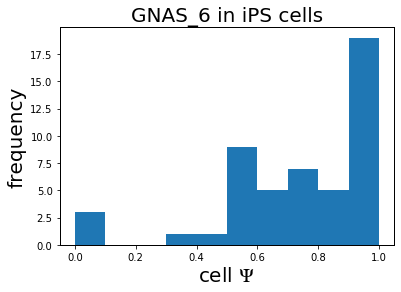

In [23]:
plt.hist(song_outrigger.loc[outrigger_iPSC, 
                   'exon:chr20:57470667-57470739:+@exon:chr20:57473996-57474040:+@exon:chr20:57478586-57478640:+'].dropna())
plt.title('GNAS_6 in iPS cells', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.xlabel('cell $\Psi$', fontsize=20)
plt.show()

In [25]:
total = [] 
bimodal_total = [] 
filtered = [] 
bimodal_filtered = [] 
pvals =[] 


cells_in_cluster = []

cells_in_cluster.extend([len(x) for x in [chen_clust_filter[x][0].columns for x in range(len(chen_clust_filter))]])
cells_in_cluster.extend([len(x) for x in [lescroart_E6, lescroart_E7]])
cells_in_cluster.extend([len(x) for x in [trapnell_clust_filter[x][0].columns for x in range(len(trapnell_clust_filter))]])
cells_in_cluster.extend([len(x) for x in [song_clust_filter[x][0].columns for x in range(len(song_clust_filter))]])
cells_in_cluster.append(len(shalek_PSI.columns))
cells_in_cluster.append(len(das_PSI.columns))


chen_processed = test_dset(chen_PSI, [chen_clust_filter[x][0].columns for x in range(len(chen_clust_filter))], 
                           chen_mrna_counts, mrna_per_event_chen, 
          chen_read_counts, chen_coverage_tab, psi_int = 0.2, mrna_min = 10)

lescroart_processed = test_dset(lescroart_PSI, [lescroart_E6, lescroart_E7], lescroart_mrna_counts, mrna_per_event_lescroart, 
          lescroart_read_counts, lescroart_coverage_tab, psi_int = 0.2, mrna_min = 10)

trapnell_processed = test_dset(trapnell_PSI, [trapnell_clust_filter[x][0].columns for x in range(len(trapnell_clust_filter))], 
                               trapnell_mrna_counts, mrna_per_event_trapnell, trapnell_read_counts, 
                               trapnell_coverage_tab, psi_int = 0.2, mrna_min = 10)

song_processed = test_dset(song_PSI, [song_clust_filter[x][0].columns for x in range(len(song_clust_filter))], 
                           song_mrna_counts, mrna_per_event_song, 
          song_read_counts, song_coverage_tab, psi_int = 0.2, mrna_min = 10)

shalek_processed = test_dset(shalek_PSI, [shalek_PSI.columns], shalek_mrna_counts, mrna_per_event_shalek, 
          shalek_read_counts, shalek_coverage_tab, psi_int = 0.2, mrna_min = 10)

das_processed = test_dset(das_PSI, [das_PSI.columns], das_mrna_counts, mrna_per_event_das, 
          das_read_counts, das_coverage_tab, psi_int = 0.2, mrna_min = 10)


total.extend(chen_processed[0])
total.extend(lescroart_processed[0])
total.extend(trapnell_processed[0])
total.extend(song_processed[0])
total.extend(shalek_processed[0])
total.extend(das_processed[0])

bimodal_total.extend(chen_processed[1])
bimodal_total.extend(lescroart_processed[1])
bimodal_total.extend(trapnell_processed[1])
bimodal_total.extend(song_processed[1])
bimodal_total.extend(shalek_processed[1])
bimodal_total.extend(das_processed[1])

filtered.extend(chen_processed[2])
filtered.extend(lescroart_processed[2])
filtered.extend(trapnell_processed[2])
filtered.extend(song_processed[2])
filtered.extend(shalek_processed[2])
filtered.extend(das_processed[2])

bimodal_filtered.extend(chen_processed[3])
bimodal_filtered.extend(lescroart_processed[3])
bimodal_filtered.extend(trapnell_processed[3])
bimodal_filtered.extend(song_processed[3])
bimodal_filtered.extend(shalek_processed[3])
bimodal_filtered.extend(das_processed[3])

pvals.extend(chen_processed[4])
pvals.extend(lescroart_processed[4])
pvals.extend(trapnell_processed[4])
pvals.extend(song_processed[4])
pvals.extend(shalek_processed[4])
pvals.extend(das_processed[4])

Total intermediate exons: 446
Total intermediate exons that are bimodal by quartile definition: 118
#################
Selected exons: 94
Selected exons that are bimodal by Song et al. definition: 0
Selected exons that are bimodal by quartile definition: 0
#################
Depletion of quartile bimodality in selected exon (p-value): 4.089694836903887e-15
Total intermediate exons: 402
Total intermediate exons that are bimodal by quartile definition: 107
#################
Selected exons: 98
Selected exons that are bimodal by Song et al. definition: 0
Selected exons that are bimodal by quartile definition: 1
#################
Depletion of quartile bimodality in selected exon (p-value): 1.7433419418207195e-14
Total intermediate exons: 516
Total intermediate exons that are bimodal by quartile definition: 136
#################
Selected exons: 76
Selected exons that are bimodal by Song et al. definition: 0
Selected exons that are bimodal by quartile definition: 1
#################
Depletion o

In [26]:
pval_adj = multipletests(pvals, method='fdr_bh')[1]

cell_type = ['ES', 'Epi, early', 'Epi, late', 'Motor neuron, early', 'Motor neuron, late', 'Heart E6.75', 'Heart E7.25', 
             'Myoblast 00h', 'Myoblast 24h', 'Myoblast 48h', 'Myoblast 72h',
             'iPSC', 'NPC', 'Motor neuron', 'BMDC', 'Olfactory neurons']
dataset = ['Chen']*5 + ['Lescroart']*2 + ['Trapnell']*4 + ['Song']*3 + ['Shalek'] + ['Fletcher']
organism = ['Mouse']*7+['Human']*7+['Mouse']*2

bimodality_table = pd.DataFrame()
bimodality_table['dataset'] = dataset
bimodality_table['organism'] = organism
bimodality_table['cell_type'] = cell_type
bimodality_table['cells_in_cluster'] = cells_in_cluster
bimodality_table['total_exons'] = total
bimodality_table['bimodal_exons'] = bimodal_total
bimodality_table['bimodal_percent'] = [str(round(x*100, 2))+'%' for x in np.array(bimodal_total)/np.array(total)]
bimodality_table['selected_exons'] = filtered
bimodality_table['selected_bimodal'] = bimodal_filtered
bimodality_table['bimodal_percent_selected'] = [str(round(x*100, 2))+'%' for x in np.array(bimodal_filtered)/np.array(filtered)]
bimodality_table['p-val'] = pvals
bimodality_table['p-val (adj)'] = pval_adj

In [27]:
bimodality_table

,dataset,organism,cell_type,cells_in_cluster,total_exons,bimodal_exons,bimodal_percent,selected_exons,selected_bimodal,bimodal_percent_selected,p-val,p-val (adj)
0,Chen,Mouse,ES,217,446,118,26.46%,94,0,0.0%,4.089695e-15,3.271756e-14
1,Chen,Mouse,"Epi, early",98,402,107,26.62%,98,1,1.02%,1.743342e-14,9.297824e-14
2,Chen,Mouse,"Epi, late",104,516,136,26.36%,76,1,1.32%,2.969315e-10,1.111313e-09
3,Chen,Mouse,"Motor neuron, early",47,364,117,32.14%,43,0,0.0%,1.559634e-08,3.564878e-08
4,Chen,Mouse,"Motor neuron, late",22,517,146,28.24%,61,0,0.0%,3.472852e-10,1.111313e-09
5,Lescroart,Mouse,Heart E6.75,172,286,77,26.92%,33,0,0.0%,1.512964e-05,2.017286e-05
6,Lescroart,Mouse,Heart E7.25,341,291,78,26.8%,36,0,0.0%,5.495198e-06,7.993016e-06
7,Trapnell,Human,Myoblast 00h,35,400,142,35.5%,41,0,0.0%,4.519740e-09,1.205264e-08
8,Trapnell,Human,Myoblast 24h,89,251,97,38.65%,27,0,0.0%,7.074301e-07,1.162529e-06
9,Trapnell,Human,Myoblast 48h,72,242,97,40.08%,32,1,3.12%,4.541607e-07,9.083215e-07


In [28]:
bimodality_table.to_csv('selected_int_exons_agg_clusters.csv', index=False, header=True)